In [ ]:
from google.colab import  drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.31.168.210:8470
REPLICAS:  8


In [ ]:
sns.set_style("whitegrid")

In [ ]:
IMAGES_PATH = Path("/content/drive/MyDrive/farm_insects")
encoder = LabelEncoder()

def create_images_df() -> pd.DataFrame:
    dfs = []
    for dir in IMAGES_PATH.iterdir():
        df = pd.DataFrame({"image_label": dir.name, "image_path": [str(path) for path in dir.iterdir()]})
        dfs.append(df)

    return (pd.concat(dfs)
            .assign(encoded_label = lambda df: encoder.fit_transform(df.image_label))
            .sample(len(pd.concat(dfs)), random_state=0)
            .reset_index(drop=True))



In [ ]:
images_df = create_images_df()
images_df

image_label  \
0     Africanized Honey Bees (Killer Bees)   
1                              Corn Borers   
2                             Spider Mites   
3                  Colorado Potato Beetles   
4                   Western Corn Rootworms   
...                                    ...   
1586                          Spider Mites   
1587                         Citrus Canker   
1588  Africanized Honey Bees (Killer Bees)   
1589                        Fall Armyworms   
1590                          Spider Mites   

                                             image_path  encoded_label  
0     /content/drive/MyDrive/farm_insects/Africanize...              0  
1     /content/drive/MyDrive/farm_insects/Corn Borer...              7  
2     /content/drive/MyDrive/farm_insects/Spider Mit...             11  
3     /content/drive/MyDrive/farm_insects/Colorado P...              6  
4     /content/drive/MyDrive/farm_insects/Western Co...             14  
...                                                 ...            ...  
1586  /content/drive/MyDrive/farm_insects/Spider Mit...             11  
1587  /content/drive/MyDrive/farm_insects/Citrus Can...              5  
1588  /content/drive/MyDrive/farm_insects/Africanize...              0  
1589  /content/drive/MyDrive/farm_insects/Fall Armyw...              9  
1590  /content/drive/MyDrive/farm_insects/Spider Mit...             11  

[1591 rows x 3 columns]

Text(0.5, 1.0, 'Distribution of Image Classes')

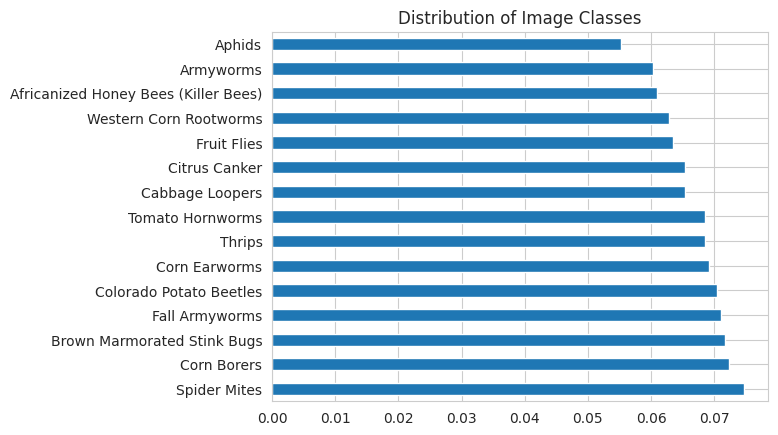

In [ ]:
images_df.image_label.value_counts(normalize=True).plot.barh()
plt.title("Distribution of Image Classes")

In [ ]:
#split images
train, test = train_test_split(images_df, test_size=0.2, random_state=0)
val, test = train_test_split(test, test_size=0.2, random_state=0)
print(f"""
training set: {train.shape[0]}
validation set: {val.shape[0]}
test set: {test.shape[0]}""")


training set: 1272
validation set: 255
test set: 64


In [ ]:
# compute class weights for each class in train data set
train_class_weights = dict((len(train) / (train.encoded_label.value_counts() * 15)).round(4))
train_class_weights

{11: 0.8314,
 9: 0.8926,
 6: 0.9021,
 8: 0.9118,
 13: 0.9217,
 7: 0.9319,
 3: 0.9636,
 5: 0.9976,
 12: 1.0217,
 10: 1.0217,
 4: 1.06,
 2: 1.1307,
 14: 1.1616,
 0: 1.1778,
 1: 1.2848}

In [ ]:
def convert_image_to_tensor(img_path: str) -> tf.Tensor:
    with open(img_path, "rb") as f:
      img = f.read()

    img = tf.image.decode_image(img, channels=3)

    # resize image to 224px by 224px
    img = tf.image.resize(img, [224, 224])

    # normalise image so that maximum value is 1 and minimum is 0
    img = img / 255.

    return img

In [ ]:
from typing import Tuple, Union
def create_ds(image_data: Union[list, np.array]) -> np.array:
    ds = np.empty((len(image_data),) + (224, 224, 3), dtype=np.float32)

    for index, image in enumerate(image_data):
        ds[index] = image
    return ds


In [ ]:
train_image_list = [convert_image_to_tensor(image_path) for image_path in train.image_path.values]
val_image_list = [convert_image_to_tensor(image_path) for image_path in val.image_path.values]
test_image_list = [convert_image_to_tensor(image_path) for image_path in test.image_path.values]

In [ ]:
train_ds = create_ds(train_image_list)
val_ds = create_ds(val_image_list)
test_ds = create_ds(test_image_list)

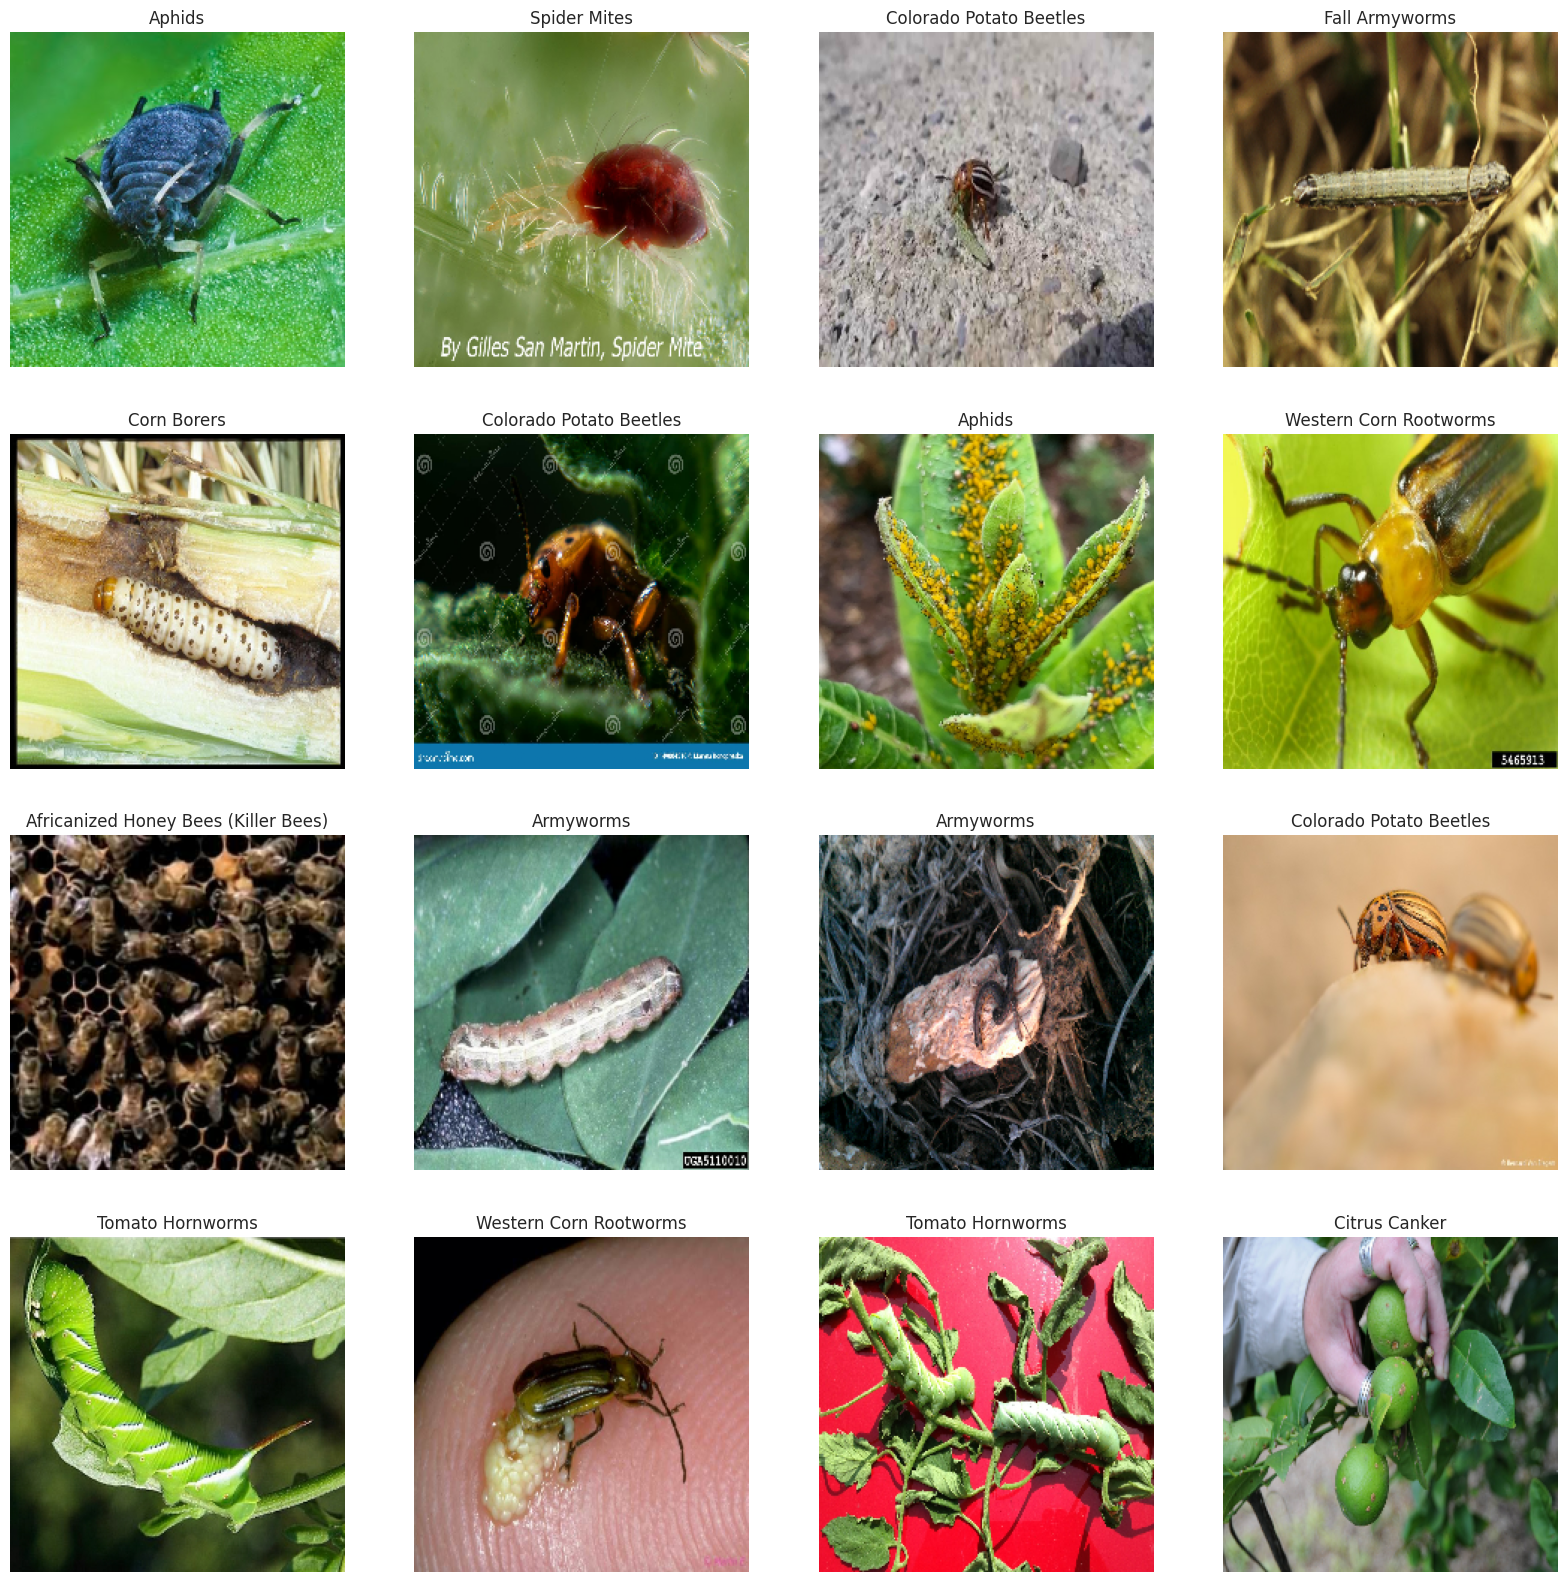

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

for image, label, ax in zip(train_ds[:16], train.encoded_label[:16], axs.flat):
    ax.imshow(image)
    ax.set_title(encoder.inverse_transform([label])[0])
    ax.set_axis_off()

In [ ]:
def create_model() -> keras.Model:

    input = keras.Input([224, 224, 3])

    # defining first block
    x = keras.layers.Conv2D(32, 3, strides=1, activation="relu", kernel_regularizer=keras.regularizers.l1_l2())(input)
    x = keras.layers.MaxPooling2D()(x)



    # defining second block
    x = keras.layers.Conv2D(64, 3, strides=1, activation="relu", kernel_regularizer=keras.regularizers.l2())(x)
    x = keras.layers.MaxPooling2D()(x)
    x = keras.layers.Dropout(0.3)(x)

    # defining third block
    x = keras.layers.Conv2D(16, 3, strides=1, activation="relu", kernel_regularizer=keras.regularizers.l2())(x)
    x = keras.layers.MaxPooling2D()(x)
    x = keras.layers.Dropout(0.3)(x)

    # defining fourth block
    x = keras.layers.Conv2D(32, 3, strides=1, activation="relu", kernel_regularizer=keras.regularizers.l2())(x)
    x = keras.layers.AveragePooling2D()(x)
    x = keras.layers.Dropout(0.3)(x)



    #flatten layer
    x = keras.layers.Flatten()(x)

    x = keras.layers.Dense(224)(x)

    x = keras.layers.Dropout(0.5)(x)


    output = keras.layers.Dense(15, activation="softmax")(x)

    model = keras.Model(input, output)
    model.compile(
            optimizer = keras.optimizers.Adam(),
            loss = keras.losses.SparseCategoricalCrossentropy(),
            metrics =  ["accuracy"]
        )

    return model

In [ ]:
def create_resnet_model() -> keras.Model:
    pretrained = keras.applications.ResNet50(
        include_top = False,
        input_shape = (224, 224, 3)
    )

    pretrained.trainable = False

    input = pretrained.input
    flat = keras.layers.Flatten()(pretrained.output)
    output = keras.layers.Dense(15, activation="softmax")(flat)

    model = keras.Model(input, output)
    model.compile(
            optimizer = keras.optimizers.Adam(learning_rate=1e-5),
            loss = keras.losses.SparseCategoricalCrossentropy(),
            metrics =  ["accuracy"]
        )

    return model

In [ ]:
augment = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
    keras.layers.RandomContrast(0.2)
])

In [ ]:
model = create_resnet_model()

In [ ]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_14[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
def lr_scheduler(epoch, start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0, exp_decay = 0.8):

    def scheduler(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)

        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr

    return scheduler(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)



early_stopping = keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 10,
    min_delta = 0.001,
    restore_best_weights = True
)

learning_rate_scheduler = keras.callbacks.LearningRateScheduler(lr_scheduler)

checkpoint = keras.callbacks.ModelCheckpoint(
    save_best_only = True,
    filepath = "/content/drive/MyDrive/saved_models/callback_best_model.h5"
)

callbacks = [early_stopping, checkpoint]

In [ ]:
BATCH_SIZE = 32

In [ ]:
hist = model.fit(augment(train_ds), train.encoded_label.values,
                    validation_data=(val_ds, val.encoded_label.values),
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks,
                    steps_per_epoch = len(train_ds) // BATCH_SIZE,
                    validation_steps = len(val_ds) // BATCH_SIZE,
                    epochs=100)

Epoch 1/100
39/39 [==============================] - 26s 588ms/step - loss: 2.8430 - accuracy: 0.0537 - val_loss: 2.7420 - val_accuracy: 0.0848
Epoch 2/100
39/39 [==============================] - 18s 466ms/step - loss: 2.7195 - accuracy: 0.0734 - val_loss: 2.6973 - val_accuracy: 0.0670
Epoch 3/100
39/39 [==============================] - 18s 459ms/step - loss: 2.6994 - accuracy: 0.0871 - val_loss: 2.6918 - val_accuracy: 0.0938
Epoch 4/100
39/39 [==============================] - 15s 388ms/step - loss: 2.6813 - accuracy: 0.0927 - val_loss: 2.6979 - val_accuracy: 0.1071
Epoch 5/100
39/39 [==============================] - 15s 385ms/step - loss: 2.6709 - accuracy: 0.0984 - val_loss: 2.7042 - val_accuracy: 0.0938
Epoch 6/100
39/39 [==============================] - 18s 455ms/step - loss: 2.6755 - accuracy: 0.0952 - val_loss: 2.6876 - val_accuracy: 0.0893
Epoch 7/100
39/39 [==============================] - 17s 450ms/step - loss: 2.6438 - accuracy: 0.1242 - val_loss: 2.6875 - val_accuracy:

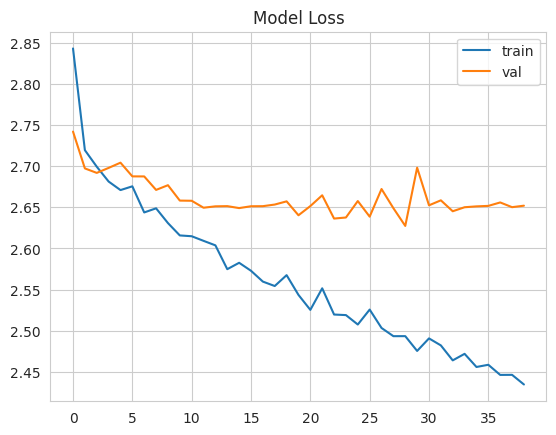

In [ ]:
plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="val")
plt.title("Model Loss")
plt.legend()
plt.show()

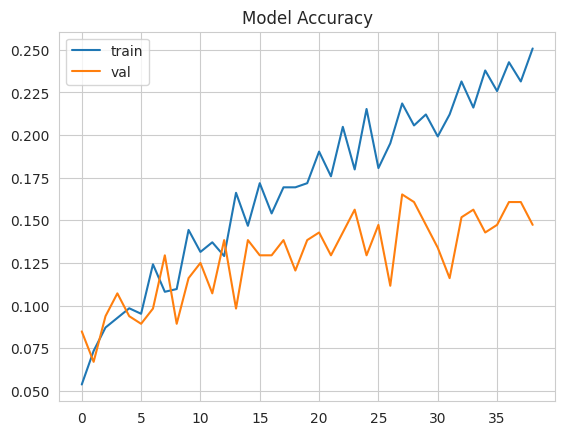

In [ ]:
plt.plot(hist.history["accuracy"], label="train")
plt.plot(hist.history["val_accuracy"], label="val")
plt.title("Model Accuracy")
plt.legend()
plt.show()